# **Initialize Spark**

In [1]:
from pyspark.sql import SparkSession

APP_NAME = "HPC Lab"
SPARK_URL = "local[4]"
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sc = spark.sparkContext
spark.sparkContext.defaultParallelism

12

In [2]:
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")

In [3]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

# **Day of the week with highest tip percentage**

**RDD Approach**

In [4]:
import datetime

def get_day_of_week(date_obj):
    return date_obj.strftime('%A')


def calculate_percentage(tip, fare):
    if fare != 0:
        return (tip / fare) * 100
    else:
        return 0

def calculate_average(lst):
    return sum(lst) / len(lst)

df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")


In [5]:
rdd = df.rdd
rdd = rdd.map(lambda x: (x[1], x[10], x[13]))  # Drop every column but date, fare amount, and tip amount

# Map to get day of the week and a tuple (sum of percentage for the record, count of records)
rdd = rdd.map(lambda x: (get_day_of_week(x[0]), (calculate_percentage(x[2], x[1]), 1)))

# Reduce by key to accumulate the sum of percentages and counts
rdd = rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate average tip percentage
rdd = rdd.map(lambda x: (x[0], x[1][0] / x[1][1])).sortBy(lambda x: x[1], ascending=False)

for day, avg_percentage in rdd.collect():
    print(f"{day}: {avg_percentage:.2f}%")


Thursday: 18.04%
Tuesday: 15.42%
Sunday: 15.36%
Monday: 15.14%
Saturday: 14.05%
Friday: 13.53%
Wednesday: 10.05%


# **Most common taxi trips**

**DF Approach**

In [6]:
from pyspark.sql import functions as F
import time

# Read the trip data CSV file into a DataFrame with specified options
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")

# Read the zones lookup CSV file into another DataFrame
zones_df = spark.read.csv("taxi+_zone_lookup.csv", header=True, inferSchema=True)

# Select only the "PULocationID" and "DOLocationID" columns from the trip data
df = df.select("PULocationID", "DOLocationID")

# Filter out rows where "PULocationID" or "DOLocationID" are equal to 264 (Unknown neighborhoods)
df = df.filter((df.PULocationID != 264) & (df.DOLocationID != 264))

# Group by "PULocationID" and "DOLocationID" and count occurrences to determine popular routes
df_counts = df.groupBy("PULocationID", "DOLocationID").count()

# Join the counts DataFrame with the zones DataFrame to add location details for both pickup and dropoff
# The zones DataFrame is renamed appropriately for each join operation
result_df = df_counts.join(zones_df.withColumnRenamed("LocationID", "PULocationID"), on="PULocationID") \
                     .withColumnRenamed("Borough", "PUBorough") \
                     .withColumnRenamed("Zone", "PUZone") \
                     .withColumnRenamed("service_zone", "PUServiceZone") \
                     .join(zones_df.withColumnRenamed("LocationID", "DOLocationID"), on="DOLocationID") \
                     .withColumnRenamed("Borough", "DOBorough") \
                     .withColumnRenamed("Zone", "DOZone") \
                     .withColumnRenamed("service_zone", "DOServiceZone")\
                     .orderBy(F.col("count").desc())  # Order results by count in descending order

# Measure time only for the action
start_time = time.time()
result_df.show(10)
end_time = time.time()

# Calculate elapsed time and amount of data processed
elapsed_time = end_time - start_time
data_count = result_df.count()

# Calculate processing speed
processing_speed = data_count / elapsed_time

print(f"Elapsed time: {round(elapsed_time, 3)} seconds")
print(f"Amount of Data Processed: {data_count} records")
print(f"Processing Speed: {processing_speed} records/second")

+------------+------------+-----+---------+--------------------+-------------+---------+--------------------+-------------+
|DOLocationID|PULocationID|count|PUBorough|              PUZone|PUServiceZone|DOBorough|              DOZone|DOServiceZone|
+------------+------------+-----+---------+--------------------+-------------+---------+--------------------+-------------+
|         236|         237| 3433|Manhattan|Upper East Side S...|  Yellow Zone|Manhattan|Upper East Side N...|  Yellow Zone|
|         236|         236| 3174|Manhattan|Upper East Side N...|  Yellow Zone|Manhattan|Upper East Side N...|  Yellow Zone|
|         237|         236| 3011|Manhattan|Upper East Side N...|  Yellow Zone|Manhattan|Upper East Side S...|  Yellow Zone|
|         246|         230| 2944|Manhattan|Times Sq/Theatre ...|  Yellow Zone|Manhattan|West Chelsea/Huds...|  Yellow Zone|
|          79|          79| 2939|Manhattan|        East Village|  Yellow Zone|Manhattan|        East Village|  Yellow Zone|
|       

**RDD Approach**

In [7]:
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")
rdd = df.rdd

# Extract pairs of PULocationID and DOLocationID
pairs = rdd.map(lambda fields: (fields[7], fields[8]))

# Filter out records where either PULocationID or DOLocationID is 264
filtered_pairs = pairs.filter(lambda x: x[0] != 264 and x[1] != 264)

# Generate pairs with an initial count of 1 for each combination
pair_counts = filtered_pairs.map(lambda pair: (pair, 1))

# Sum up the counts for each combination
combined_counts = pair_counts.reduceByKey(lambda a, b: a + b)

zones_df = spark.read.csv("taxi+_zone_lookup.csv", header=True, inferSchema=True)

# Create a mapping of LocationID to details (Borough, Zone, service_zone)
locationDetailsRDD = zones_df.rdd.map(lambda row: (row["LocationID"], (row["Borough"], row["Zone"], row["service_zone"])))



# Join on PULocationID
rdd_PU = combined_counts.map(lambda x: (x[0][0], (x[0][1], x[1])))
joined_with_PU = rdd_PU.join(locationDetailsRDD)

# Reformat for the second join
reformatted = joined_with_PU.map(lambda x: (x[1][0][0], (x[0], x[1][0][1], x[1][1][0], x[1][1][1], x[1][1][2])))
joined_with_DO = reformatted.join(locationDetailsRDD)

# Final transformation
final_rdd = joined_with_DO.map(lambda x: (x[1][0][0], x[0], x[1][0][1], x[1][0][2], x[1][0][3], x[1][0][4], x[1][1][0], x[1][1][1], x[1][1][2]))

# Sort by the 'count' field (index 2) in descending order
sorted_rdd = final_rdd.sortBy(lambda x: x[2], ascending=False)

# Start the timer just before calling any action
start_time = time.time()

# Print header
header = "PULocationID|DOLocationID|count|PUBorough|PUZone|PUServiceZone|DOBorough|DOZone|DOServiceZone"
print(header)

# Print a sample to verify
for record in sorted_rdd.take(20):  
    print("|".join(map(str, record)))

# Stop the timer immediately after executing the last action
end_time = time.time()

# Calculate elapsed time and amount of data processed
elapsed_time = end_time - start_time
data_count = sorted_rdd.count()

# Calculate processing speed
processing_speed = data_count / elapsed_time

print(f"Elapsed time: {round(elapsed_time, 3)} seconds")
print(f"Amount of Data Processed: {data_count} records")
print(f"Processing Speed: {processing_speed} records/second")

PULocationID|DOLocationID|count|PUBorough|PUZone|PUServiceZone|DOBorough|DOZone|DOServiceZone
237|236|3433|Manhattan|Upper East Side South|Yellow Zone|Manhattan|Upper East Side North|Yellow Zone
236|236|3174|Manhattan|Upper East Side North|Yellow Zone|Manhattan|Upper East Side North|Yellow Zone
236|237|3011|Manhattan|Upper East Side North|Yellow Zone|Manhattan|Upper East Side South|Yellow Zone
230|246|2944|Manhattan|Times Sq/Theatre District|Yellow Zone|Manhattan|West Chelsea/Hudson Yards|Yellow Zone
79|79|2939|Manhattan|East Village|Yellow Zone|Manhattan|East Village|Yellow Zone
237|237|2744|Manhattan|Upper East Side South|Yellow Zone|Manhattan|Upper East Side South|Yellow Zone
239|142|2595|Manhattan|Upper West Side South|Yellow Zone|Manhattan|Lincoln Square East|Yellow Zone
239|238|2539|Manhattan|Upper West Side South|Yellow Zone|Manhattan|Upper West Side North|Yellow Zone
142|239|2471|Manhattan|Lincoln Square East|Yellow Zone|Manhattan|Upper West Side South|Yellow Zone
230|186|2206|

**SQL Approach**

In [8]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder.appName("TransformToSQL").getOrCreate()

# Start timer
start_time = time.time()

# CSV into DataFrames
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")
zones_df = spark.read.csv("taxi+_zone_lookup.csv", header=True, inferSchema=True)

# Create temporal tables for DataFrames
df.createOrReplaceTempView("trip_data")
zones_df.createOrReplaceTempView("zone_lookup")

# Execute SQL
result_df = spark.sql("""
    SELECT t.PULocationID, t.DOLocationID, COUNT(*) AS count
    FROM trip_data t
    WHERE t.PULocationID != 264 AND t.DOLocationID != 264
    GROUP BY t.PULocationID, t.DOLocationID
""")
result_df.createOrReplaceTempView("route_counts")

result_df = spark.sql("""
    SELECT rc.PULocationID, rc.DOLocationID, rc.count,
           z1.Borough AS PUBorough, z1.Zone AS PUZone, z1.service_zone AS PUServiceZone,
           z2.Borough AS DOBorough, z2.Zone AS DOZone, z2.service_zone AS DOServiceZone
    FROM route_counts rc
    JOIN zone_lookup z1 ON rc.PULocationID = z1.LocationID
    JOIN zone_lookup z2 ON rc.DOLocationID = z2.LocationID
    ORDER BY rc.count DESC
""")

# Measure time only for the action
start_time = time.time()
result_df.show(10)
end_time = time.time()

# Calculate elapsed time and amount of data processed
elapsed_time = end_time - start_time
data_count = result_df.count()

# Calculate processing speed
processing_speed = data_count / elapsed_time

print(f"Elapsed time: {round(elapsed_time, 3)} seconds")
print(f"Amount of Data Processed: {data_count} records")
print(f"Processing Speed: {processing_speed} records/second")


+------------+------------+-----+---------+--------------------+-------------+---------+--------------------+-------------+
|PULocationID|DOLocationID|count|PUBorough|              PUZone|PUServiceZone|DOBorough|              DOZone|DOServiceZone|
+------------+------------+-----+---------+--------------------+-------------+---------+--------------------+-------------+
|         237|         236| 3433|Manhattan|Upper East Side S...|  Yellow Zone|Manhattan|Upper East Side N...|  Yellow Zone|
|         236|         236| 3174|Manhattan|Upper East Side N...|  Yellow Zone|Manhattan|Upper East Side N...|  Yellow Zone|
|         236|         237| 3011|Manhattan|Upper East Side N...|  Yellow Zone|Manhattan|Upper East Side S...|  Yellow Zone|
|         230|         246| 2944|Manhattan|Times Sq/Theatre ...|  Yellow Zone|Manhattan|West Chelsea/Huds...|  Yellow Zone|
|          79|          79| 2939|Manhattan|        East Village|  Yellow Zone|Manhattan|        East Village|  Yellow Zone|
|       

# **Trip distance based on passenger number**

**DF approach**

In [11]:
from pyspark.sql.functions import avg, round

# Assuming you have a DataFrame named 'df'
df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")
# Group by 'passenger_count' and calculate the average trip distance, rounding it up to two decimals
average_distance_per_passenger = df.groupBy("passenger_count").agg(round(avg("trip_distance"),2).alias("avg_trip_distance"))

# Show the result
average_distance_per_passenger.show()



+---------------+-----------------+
|passenger_count|avg_trip_distance|
+---------------+-----------------+
|              1|              3.0|
|              6|             3.14|
|              3|             3.05|
|              5|             3.15|
|              4|             3.09|
|              2|             3.11|
|              0|             0.64|
|              8|              0.0|
|              9|              0.0|
|              7|              0.0|
+---------------+-----------------+



**SQL** **approach**

In [12]:


# Register the DataFrame as a temporary table
df.createOrReplaceTempView("avg_distance_data")

# Execute SQL queries
result = spark.sql("""
    SELECT
        t.passenger_count,
        ROUND(AVG(t.trip_distance), 2)
    FROM
        avg_distance_data t
    GROUP BY t.passenger_count
    ORDER BY t.passenger_count ASC

""")

# Show the result
result.show()

+---------------+----------------------------+
|passenger_count|round(avg(trip_distance), 2)|
+---------------+----------------------------+
|              0|                        0.64|
|              1|                         3.0|
|              2|                        3.11|
|              3|                        3.05|
|              4|                        3.09|
|              5|                        3.15|
|              6|                        3.14|
|              7|                         0.0|
|              8|                         0.0|
|              9|                         0.0|
+---------------+----------------------------+



**Calculating** **correlation**

In [13]:
# We try to make a correlation between distance of trip and number of passengers
# Import of necessary PySpark functions
from pyspark.sql import functions as F

# calculation of correlation
correlation = df.select(F.corr("trip_distance", "passenger_count")).collect()[0][0]

print("Correlation between passengers and distances:", correlation)

Correlation between passengers and distances: 0.012018958036512047


# Results

In the following we compare the performance of the different approaches under varying number of cores used (as initialized by 'SPARK_URL = "local[4]"'). For this, we considered the analysis of the most common taxi trips, as this was computed using each of the three approaches. 

In order to do so, for each approach, we collected the execution time of running the programusing 1, 2, 4, 8 and 16 (max number of cores in computer used for testing) cores.  All three approaches were run four times for each number of cores in order to get an average execution time. However as can be seen from thefollowing  table,when calculating the average  we didn’t take the first run of each approach into account as their execution times were significantly higher than the others. This is presumably due to the fact that after the initial run, data was kept in memory resulting in a great decrease in execution time. This becomes most evident for the DataFrame approach which was run before the other two
In each run the identical dataset containing 16483 records was used. This was used to calculate the average processing speed.


Table 1: execution times (in seconds) and average processing speed (in records per second)

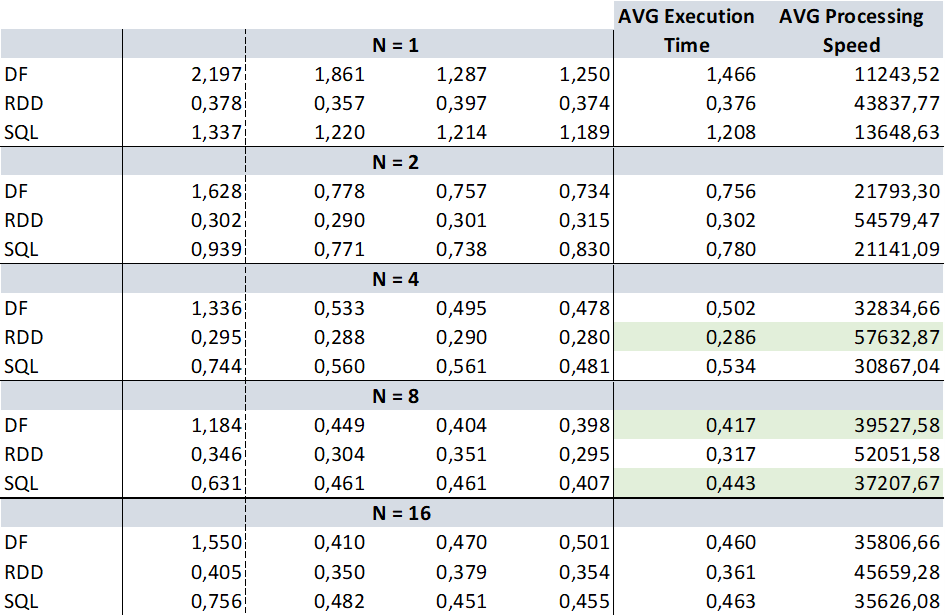

As can be seen from the table, the RDD approach showed a minimum average execution time of 0.286s for N = 4. The DF and the SQL approaches however, performed better for N = 8. 

Overall, it is evident, that the RDD approach achieved the smallest execution times and therefore, best performanc It is very noticable that the RDD approach did not perform much differently in the varying scenarios (number of cores used). The maximum achieved speedup compared to a single core used was 1.315 (for N=4), see table 2.

The DF and SQL approaches overall show very similar performances in each of the tested scenarios. Overall, a much greater speedup was achieved using multiple cores, mainly due to the low single core performance.
e.
The speedup of using multiple cores compared to one core for each of the approaches is displayed in following tablIn particular for the RDD approach it's noteworthy that the performance drops significantly after reaching a threshold of N=4. When running on 16 cores, the performance dropped almost back to the single core performance.d.


Table 2: Speedup for differnt number of cores used (N)

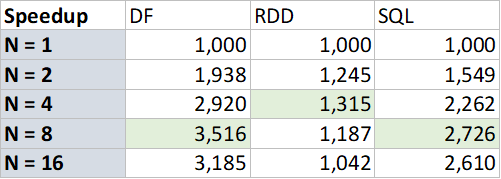